Date Created: 10/20/20
## Goal of Notebook: Morphology Prediction Based on Gene Content
Using basic ML to predict morphology based on genes in a genome

In [89]:
# importing the requests library 
import requests 
import pandas as pd
from random import sample 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns                                                             
import sys 
from sklearn import tree
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

### Can we predict morphology?

### Load in files

- Phage information: phage_metadata.csv
- Phage Genes: cleaned_gene_list.csv

In [2]:
df_phages = pd.read_csv("data/phage_metadata.csv")
df_phages.head()

,phage,temperate,cluster,subcluster,morphotype,host genus,host species,genome length,is annotated,is phamerated,gcpercent
0,20ES,True,A,A2,SIPHO,Mycobacterium,smegmatis,53124.0,False,True,63.4
1,244,True,E,NaN,SIPHO,Mycobacterium,smegmatis,74483.0,True,True,63.4
2,32HC,True,Z,NaN,SIPHO,Mycobacterium,smegmatis,50781.0,False,True,65.7
3,39HC,False,B,B6,SIPHO,Mycobacterium,smegmatis,71565.0,False,True,70.0
4,40AC,True,A,A17,SIPHO,Mycobacterium,smegmatis,53396.0,False,True,63.3


In [7]:
df_annotated_phages = df_phages[df_phages["is annotated"]==True]
df_annotated_phages.head()

,phage,temperate,cluster,subcluster,morphotype,host genus,host species,genome length,is annotated,is phamerated,gcpercent
1,244,True,E,NaN,SIPHO,Mycobacterium,smegmatis,74483.0,True,True,63.4
6,Aaronocolus,True,BD,BD1,NaN,Streptomyces,griseus,49562.0,True,True,66.2
8,AbbeyMikolon,True,BL,NaN,SIPHO,Streptomyces,lividans,42551.0,True,True,66.8
11,ABCat,True,E,NaN,SIPHO,Mycobacterium,smegmatis,76131.0,True,True,63.0
12,Abdiel,True,A,A4,SIPHO,Mycobacterium,smegmatis,51381.0,True,True,63.9


In [8]:
df_genes = pd.read_csv("data/cleaned_gene_list.csv")
df_genes.head()

,gene ID,pham,function,translation,orientation,phage,gene number,uncleaned function
0,20ES_CDS_1,36676,NKF,MYGTRSSAFWASQPGKFDVLNLRMTFPSTSAHEIPDLTATDFVPEN...,F,20ES,1,NaN
1,20ES_CDS_10,39578,lysin b,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,F,20ES,10,lysin b
2,20ES_CDS_11,34196,terminase,MSLENHHPELAPSPPHIIGPSWQRTVDGSWHLPDPKMTLGWGVLKW...,F,20ES,11,terminase
3,20ES_CDS_12,39511,portal protein,MTAPLPGQEEIPDPAIARDEMISAFDDAVKNLKINTSYYEAERRPE...,F,20ES,12,portal protein
4,20ES_CDS_13,21454,capsid maturation protease,MITAAVAAYVQRFASMFTGPALSLGEWARFLQTLFPEVQRRYAQAA...,F,20ES,13,capsid maturation protease


In [16]:
# setup sets of 
df_annotated_phages = df_annotated_phages.dropna(subset=['temperate'])
temperate_phages = df_annotated_phages[df_annotated_phages["temperate"] == 'True']
lytic_phages = df_annotated_phages[df_annotated_phages["temperate"] == 'False']

In [15]:
df_annotated_phages

,phage,temperate,cluster,subcluster,morphotype,host genus,host species,genome length,is annotated,is phamerated,gcpercent
1,244,True,E,NaN,SIPHO,Mycobacterium,smegmatis,74483.0,True,True,63.4
6,Aaronocolus,True,BD,BD1,NaN,Streptomyces,griseus,49562.0,True,True,66.2
8,AbbeyMikolon,True,BL,NaN,SIPHO,Streptomyces,lividans,42551.0,True,True,66.8
11,ABCat,True,E,NaN,SIPHO,Mycobacterium,smegmatis,76131.0,True,True,63.0
12,Abdiel,True,A,A4,SIPHO,Mycobacterium,smegmatis,51381.0,True,True,63.9
...,...,...,...,...,...,...,...,...,...,...,...
3488,Zion,False,EN,NaN,NaN,Corynebacterium,vitaeruminis,66392.0,True,True,52.3
3490,Zirinka,True,CZ,CZ1,SIPHO,Gordonia,terrae,52077.0,True,True,66.7
3495,Zonia,False,B,B1,SIPHO,Mycobacterium,smegmatis,69271.0,True,True,66.3
3496,ZooBear,False,BF,NaN,PODO,Streptomyces,griseus,46135.0,True,True,59.7


In [17]:
temperate_phages.count()

phage            398
temperate        398
cluster          398
subcluster       322
morphotype       367
host genus       398
host species     398
genome length    398
is annotated     398
is phamerated    398
gcpercent        398
dtype: int64

In [18]:
lytic_phages.count()

phage            280
temperate        280
cluster          280
subcluster       172
morphotype       262
host genus       280
host species     280
genome length    280
is annotated     280
is phamerated    280
gcpercent        280
dtype: int64

### Distribution of gene presense in temperate versus lytic phage

In [52]:
# setup function data
function_counts_temperate = {}
for func in df_genes["function"].unique():
    function_counts_temperate[func] = 0
    
for phage in temperate_phages["phage"].unique():
    functions_already_recorded = []
    for _, row in df_genes[df_genes["phage"] == phage].iterrows():
        if row["function"] in function_counts_temperate and row["function"] not in functions_already_recorded:
            function_counts_temperate[row["function"]] += 1
            functions_already_recorded.append(row["function"])

function_counts_lytic = {}
for func in df_genes["function"].unique():
    function_counts_lytic[func] = 0
    
for phage in lytic_phages["phage"].unique():
    functions_already_recorded = []
    for _, row in df_genes[df_genes["phage"] == phage].iterrows():
        if row["function"] in function_counts_lytic and row["function"] not in functions_already_recorded:
            function_counts_lytic[row["function"]] += 1
            functions_already_recorded.append(row["function"])

In [53]:
unique_temp_phages = len(temperate_phages["phage"].unique())
unique_lytic_phages = len(lytic_phages["phage"].unique())

# function_counts_temperate = sorted(function_counts_temperate.items(), key=lambda x: x[1], reverse=True)
delta_dict = {}
for function in df_genes["function"].unique():
    delta_dict[function] = function_counts_lytic[function]/unique_lytic_phages - function_counts_temperate[function]/unique_temp_phages
    
delta = sorted(delta_dict.items(), key=lambda x: x[1], reverse=True)


In [54]:
temperate_prop = []
lytic_prop = []
function_labels = []
x_pos = list(range(len(df_genes["function"].unique())))
for function, count in delta:
    temperate_prop.append(function_counts_temperate[function]/unique_temp_phages)
    lytic_prop.append(function_counts_lytic[function]/unique_lytic_phages)
    function_labels.append(function)


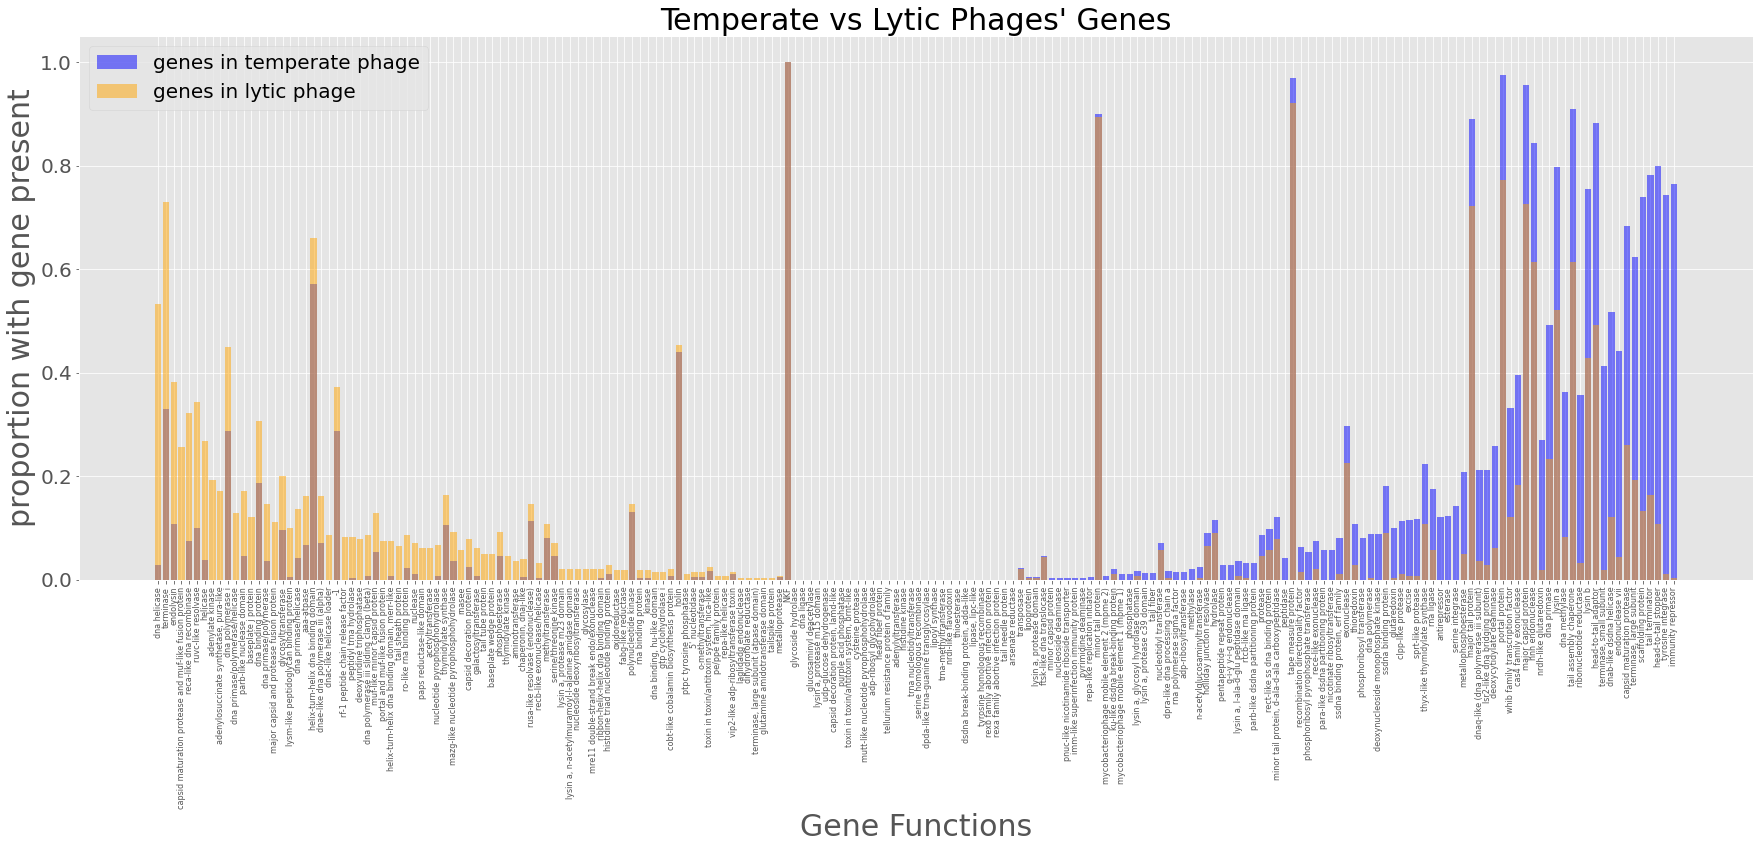

In [55]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(30,10))

plt.bar(x_pos, temperate_prop, color='blue', alpha=0.5, label = "genes in temperate phage")
plt.bar(x_pos, lytic_prop, color='orange', alpha=0.5, label = "genes in lytic phage")
plt.xlabel("Gene Functions", fontsize=30)
plt.ylabel("proportion with gene present", fontsize=30)
plt.title("Temperate vs Lytic Phages' Genes", fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(x_pos, function_labels,rotation=90, fontsize=8)
plt.legend(fontsize=20)
plt.show()

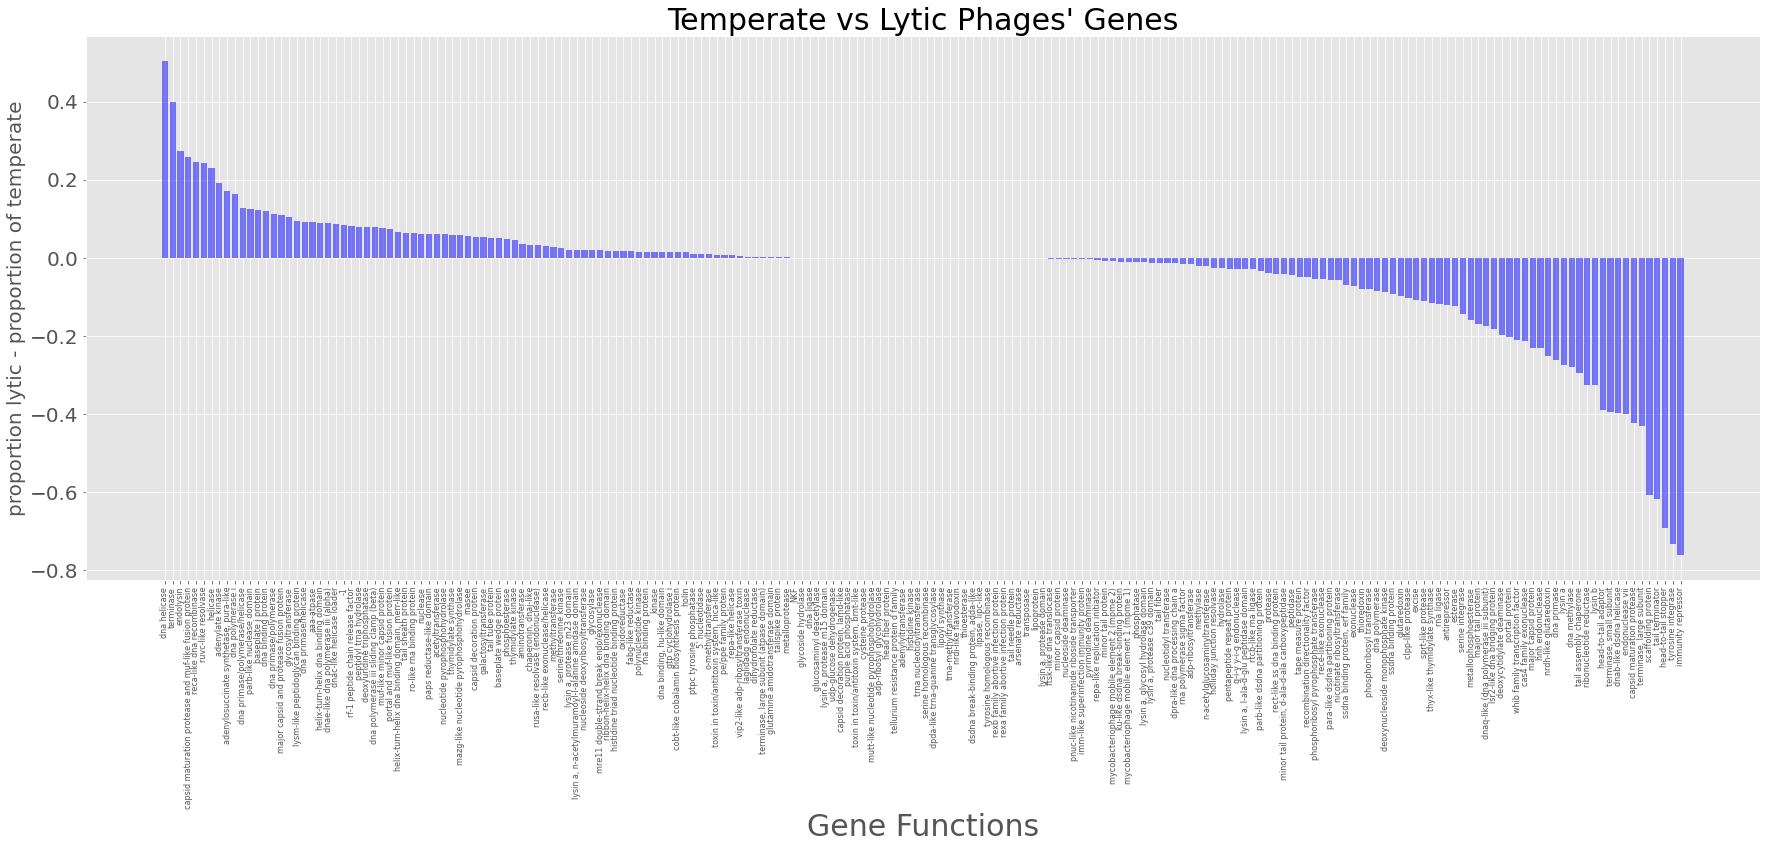

In [56]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(30,10))

plt.bar(x_pos, np.subtract(lytic_prop,temperate_prop), color='blue', alpha=0.5)
plt.xlabel("Gene Functions", fontsize=30)
plt.ylabel("proportion lytic - proportion of temperate", fontsize=20)
plt.title("Temperate vs Lytic Phages' Genes", fontsize=30)
plt.yticks(fontsize=20)

plt.xticks(x_pos, function_labels,rotation=90, fontsize=8)
plt.show()

# Random Forest Classifier

Setup feature vectors

In [116]:
feature_vector_key = {}
i = 0
for func in df_genes["function"].unique():
    feature_vector_key[func] = i
    i = i + 1

X = []
y = []
for _, phage in df_annotated_phages.iterrows():
    x = [0]*len(feature_vector_key)
    if phage["temperate"] == 'True' or phage["temperate"] == 'False':
        y.append("temperate" if phage["temperate"] else "lytic")
        for _, gene in df_genes[df_genes["phage"] == phage["phage"]].iterrows():
            x[feature_vector_key[gene["function"]]] += 1
        X.append(x)
    else:
        continue

Make testing and training data

In [117]:
test_prop = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop, random_state=42)

accuracy 1.0


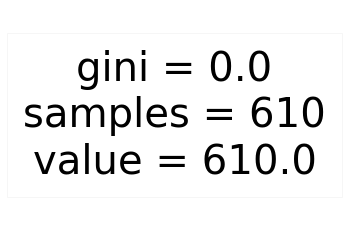

In [103]:
clf = DecisionTreeClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

print("accuracy", clf.score(X_test, y_test))
tree.plot_tree(clf)
plt.show()

Feature importances

In [104]:
for i in range(len(clf.feature_importances_)):
    if clf.feature_importances_[i] > 0:
        print(clf.feature_importances_[i],",",df_genes["function"].unique()[i])

Simple decision tree 

Graph to show tree values and structure

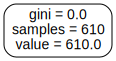

In [105]:
dot_data = tree.export_graphviz(clf,
                                out_file=None, 
                                feature_names = feature_vector_key.keys(),  
                                class_names = clf.classes_,  
                                filled = True,
                                rounded = True,  
                                special_characters = True
                               ) 

graph = graphviz.Source(dot_data)  
graph 

## Temperate or Lytic classification based on phams
This is important becuase most genomes are not annotated

In [106]:
print("number of unique phams",len(df_genes["pham"].unique()))

number of unique phams 23224


In [108]:
feature_vector_key = {}
i = 0
for func in df_genes["pham"].unique():
    feature_vector_key[func] = i
    i = i + 1

X = []
y = []
for _, phage in df_annotated_phages.iterrows():
    x = [0]*len(feature_vector_key)
    if phage["temperate"] == 'True' or phage["temperate"] == 'False':
        y.append("temperate" if phage["temperate"] else "lytic")
        for _, gene in df_genes[df_genes["phage"]==phage["phage"]].iterrows():
#             print(feature_vector_key[gene["function"]])
            x[feature_vector_key[gene["pham"]]] += 1
        X.append(x)
    else:
        continue

In [109]:
test_prop = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop, random_state=42)

accuracy 1.0


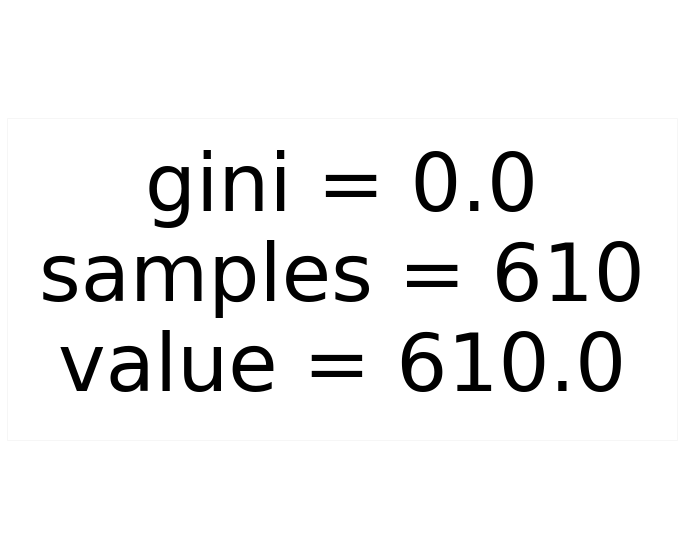

In [110]:
fig, ax = plt.subplots(figsize=(12,10))

clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X_train, y_train)
print("accuracy", clf.score(X_test, y_test))
tree.plot_tree(clf)
plt.show()

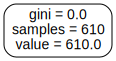

In [111]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=df_genes["pham"].unique(),  
                      class_names=clf.classes_,  
                      filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [113]:
df_genes[df_genes["pham"]==610]

,gene ID,pham,function,translation,orientation,phage,gene number,uncleaned function
24922,Bantam_CDS_157,610,NKF,MPHDIRVGDEVEEAHGWHRGRVVHIDLNGEIVVDWYPTYLNRAEDL...,R,Bantam,157,NaN
71372,Culver_CDS_159,610,NKF,MMPHDMTVGDEVCEDGGWRRGRVVHVDWSGDVTIDWYPTTYPAHTA...,R,Culver,159,NaN
75327,DatBoi_CDS_154,610,NKF,MMPHDIYVGDEVREVHGWHRGRVIHIDMNGEIAVDWYPTYLNRAED...,R,DatBoi,154,NaN
294777,SpeedDemon_CDS_155,610,NKF,MPHDIYVGDEVREVHGWHRGRVIDINMNGEIAVRWYPTYLNRAEDL...,R,SpeedDemon,155,NaN


In [114]:
majority_function = []
for pham in df_genes["pham"].unique():
    list_func = list(df_genes[df_genes["pham"]==pham]["function"])
    curr_max = -1
    maj_func = "NKF"
    for i in list_func:
        if list_func.count(i) > curr_max and i != "NKF":
            curr_max = list_func.count(i)
            maj_func = i
    prop = curr_max/len(list_func)
    majority_function.append((maj_func, pham))

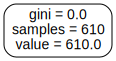

In [115]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=majority_function,  
                      class_names=clf.classes_,  
                      filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Morphology prediction based functions

In [85]:
feature_vector_key = {}
i = 0
for func in df_genes["function"].unique():
    feature_vector_key[func] = i
    i = i + 1

X = []
y = []
for _, phage in df_annotated_phages.iterrows():
    x = [0]*len(feature_vector_key)
    if phage["morphotype"] in ['SIPHO', 'MYO', 'PODO']:
        y.append(list(df_annotated_phages[df_annotated_phages["phage"]==phage["phage"]]["morphotype"])[0])
        for _, gene in df_genes[df_genes["phage"]==phage["phage"]].iterrows():
            x[feature_vector_key[gene["function"]]] += 1
        X.append(x)
    else:
        continue

In [86]:
list(df_annotated_phages[df_annotated_phages["phage"]==phage["phage"]]["morphotype"])[0]

'MYO'

In [87]:
test_prop = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop, random_state=42)

accuracy 1.0


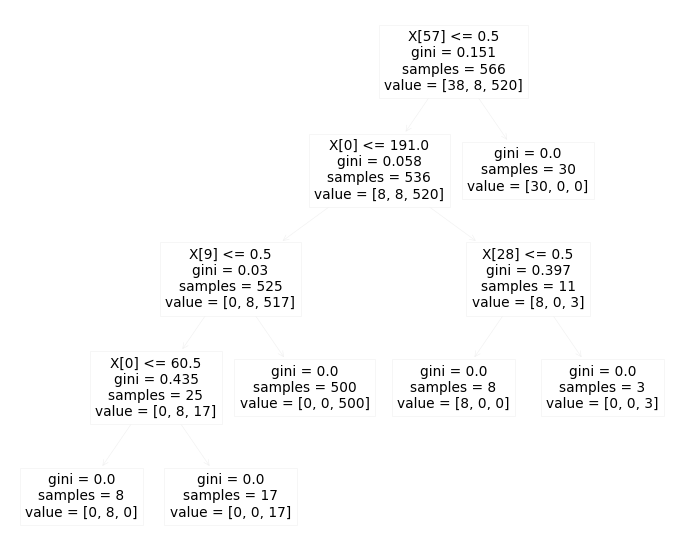

In [88]:
fig, ax = plt.subplots(figsize=(12,10))

clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, y_train)
print("accuracy", clf.score(X_test, y_test))
tree.plot_tree(clf)
plt.show()

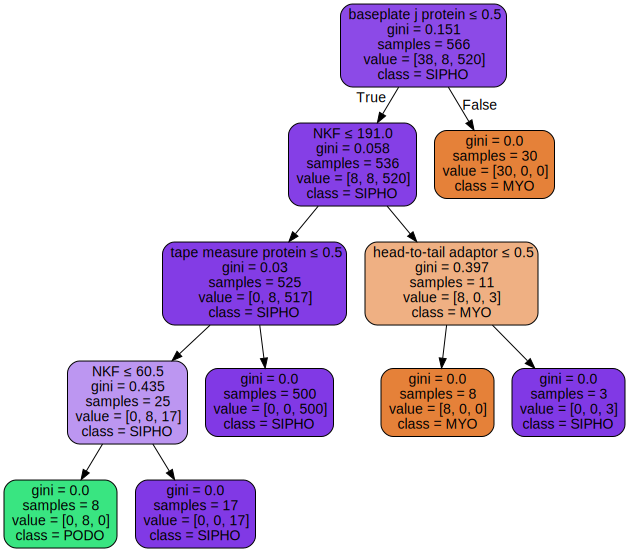

In [89]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=df_genes["function"].unique(),  
                      class_names=clf.classes_,  
                      filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Morphology prediction based phams

In [90]:
feature_vector_key = {}
i = 0
for func in df_genes["pham"].unique():
    feature_vector_key[func] = i
    i = i + 1

X = []
y = []
for _, phage in df_annotated_phages.iterrows():
    x = [0]*len(feature_vector_key)
    if phage["morphotype"] in ['SIPHO', 'MYO', 'PODO']:
        y.append(list(df_annotated_phages[df_annotated_phages["phage"]==phage["phage"]]["morphotype"])[0])
        for _, gene in df_genes[df_genes["phage"]==phage["phage"]].iterrows():
#             print(feature_vector_key[gene["function"]])
            x[feature_vector_key[gene["pham"]]] += 1
        X.append(x)
    else:
        continue

In [91]:
test_prop = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop, random_state=42)

accuracy 1.0


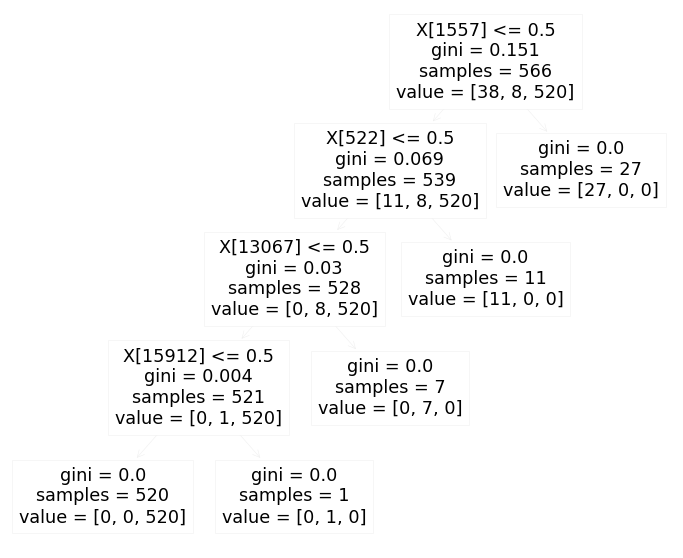

In [92]:
fig, ax = plt.subplots(figsize=(12,10))

clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, y_train)
print("accuracy", clf.score(X_test, y_test))
tree.plot_tree(clf)
plt.show()

In [93]:
majority_function = []
for pham in df_genes["pham"].unique():
    list_func = list(df_genes[df_genes["pham"]==pham]["function"])
    curr_max = -1
    maj_func = "NKF"
    for i in list_func:
        if list_func.count(i) > curr_max and i != "NKF":
            curr_max = list_func.count(i)
            maj_func = i
    prop = curr_max/len(list_func)
    majority_function.append((maj_func, pham))

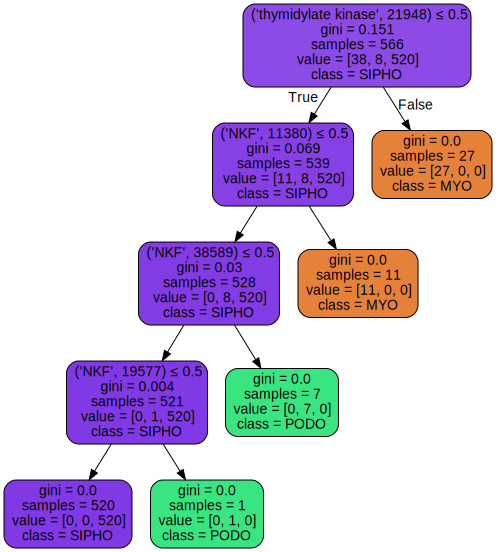

In [94]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=majority_function,  
                      class_names=clf.classes_,  
                      filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Using full dataset predict morphotype based on phage occurance

In [95]:
feature_vector_key = {}
i = 0
for func in df_genes["pham"].unique():
    feature_vector_key[func] = i
    i = i + 1

X = []
y = []
for _, phage in df_phages.iterrows():
    x = [0]*len(feature_vector_key)
    if phage["morphotype"] in ['SIPHO', 'MYO', 'PODO']:
        y.append(list(df_phages[df_phages["phage"]==phage["phage"]]["morphotype"])[0])
        for _, gene in df_genes[df_genes["phage"]==phage["phage"]].iterrows():
#             print(feature_vector_key[gene["function"]])
            x[feature_vector_key[gene["pham"]]] += 1
        X.append(x)
    else:
        continue

In [96]:
test_prop = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop, random_state=42)

accuracy 0.9898305084745763


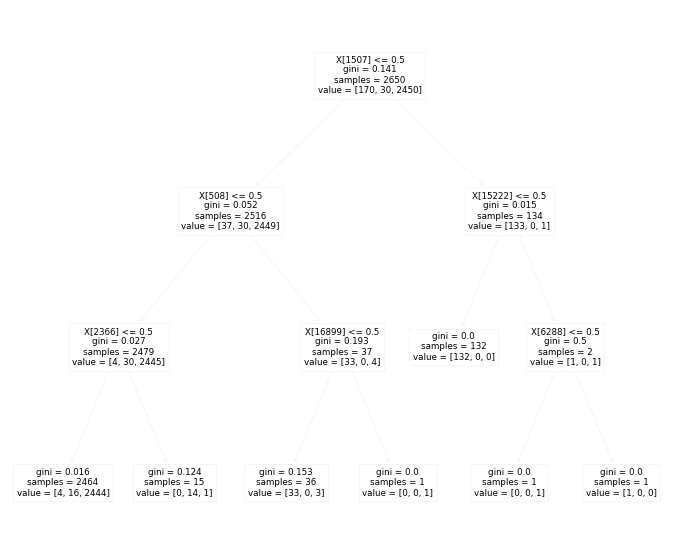

In [97]:
fig, ax = plt.subplots(figsize=(12,10))

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)
print("accuracy", clf.score(X_test, y_test))
tree.plot_tree(clf)
plt.show()

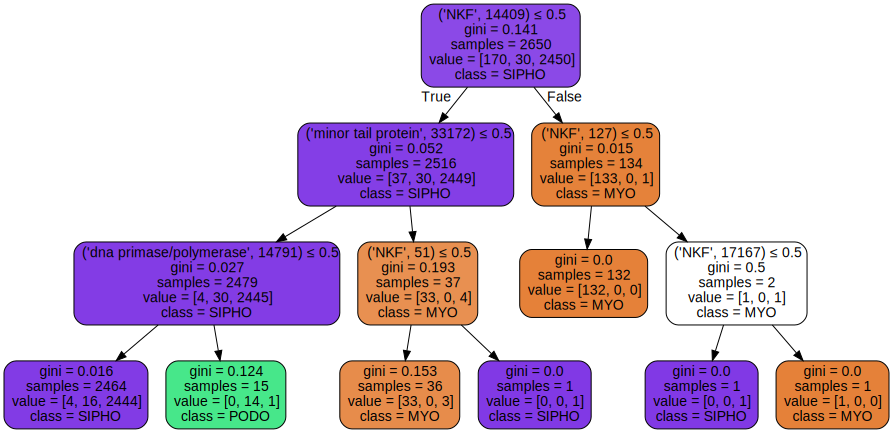

In [98]:
majority_function = []
for pham in df_genes["pham"].unique():
    list_func = list(df_genes[df_genes["pham"]==pham]["function"])
    curr_max = -1
    maj_func = "NKF"
    for i in list_func:
        if list_func.count(i) > curr_max and i != "NKF":
            curr_max = list_func.count(i)
            maj_func = i
    prop = curr_max/len(list_func)
    majority_function.append((maj_func, pham))

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=majority_function,  
                      class_names=clf.classes_,  
                      filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [99]:
len(df_phages[df_phages["morphotype"] == "SIPHO"])

2718

In [100]:
clf.classes_

array(['MYO', 'PODO', 'SIPHO'], dtype='<U5')

### Host species prediction based on pham

In [101]:
df_phages.head()

,phage,temperate,cluster,subcluster,morphotype,host genus,host species,genome length,is annotated,is phamerated,gcpercent
0,20ES,True,A,A2,SIPHO,Mycobacterium,smegmatis,53124,False,True,63.4
1,244,True,E,NaN,SIPHO,Mycobacterium,smegmatis,74483,True,True,63.4
2,32HC,True,Z,NaN,SIPHO,Mycobacterium,smegmatis,50781,False,True,65.7
3,39HC,False,B,B6,SIPHO,Mycobacterium,smegmatis,71565,False,True,70.0
4,40AC,True,A,A17,SIPHO,Mycobacterium,smegmatis,53396,False,True,63.3


In [102]:
df_phages["host species"].unique()

array(['smegmatis', 'griseus', 'globiformis', 'lividans', 'sp. ',
       'sulfureus', 'xerosis', 'terrae', 'atrocyaneus', 'foliorum',
       'erythropolis', 'rubripertincta', 'paraoxydans', 'azureus',
       'platensis', 'venezuelae', 'xanthochromogenes', 'avium',
       'freudenreichii', 'acnes', 'westfalica', 'testaceum', 'phlei',
       'sanglieri', 'viridochromogenes', 'griseofuscus', 'sp.',
       'vitaeruminis', 'aerolatum', 'fuscum', 'radiodurans', 'mirabilis',
       'scabiei', 'equi', 'tuberculosis', 'flavescens', 'neofelifaecis',
       'alkanivorans', 'malaquae', 'toxytricini', 'sputi', 'aichiense',
       'abscessus', 'liquefaciens', 'virginiae', 'iodinum', 'indigocolor',
       'nematophilum', 'aureofaciens', 'coelicolor', 'avermitilis',
       'globerulus', 'rhodochrous', 'tricolor', 'himastatinicus',
       'dentocariosa', 'roseosporus', 'natoriense', 'jenkinsii',
       'paurometabola'], dtype=object)

In [103]:
feature_vector_key = {}
i = 0
for func in df_genes["pham"].unique():
    feature_vector_key[func] = i
    i = i + 1

X = []
y = []
for _, phage in df_phages.iterrows():
    x = [0]*len(feature_vector_key)
    if phage["morphotype"] != None:
        y.append(list(df_phages[df_phages["phage"]==phage["phage"]]["host species"])[0])
        for _, gene in df_genes[df_genes["phage"]==phage["phage"]].iterrows():
#             print(feature_vector_key[gene["function"]])
            x[feature_vector_key[gene["pham"]]] += 1
        X.append(x)
    else:
        continue

In [104]:
test_prop = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop, random_state=42)

accuracy 0.6114285714285714


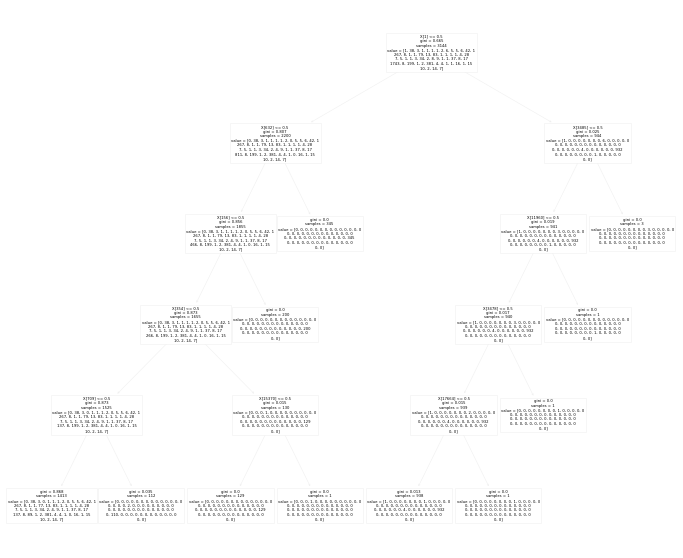

In [105]:
fig, ax = plt.subplots(figsize=(12,10))

clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, y_train)
print("accuracy", clf.score(X_test, y_test))
tree.plot_tree(clf)
plt.show()

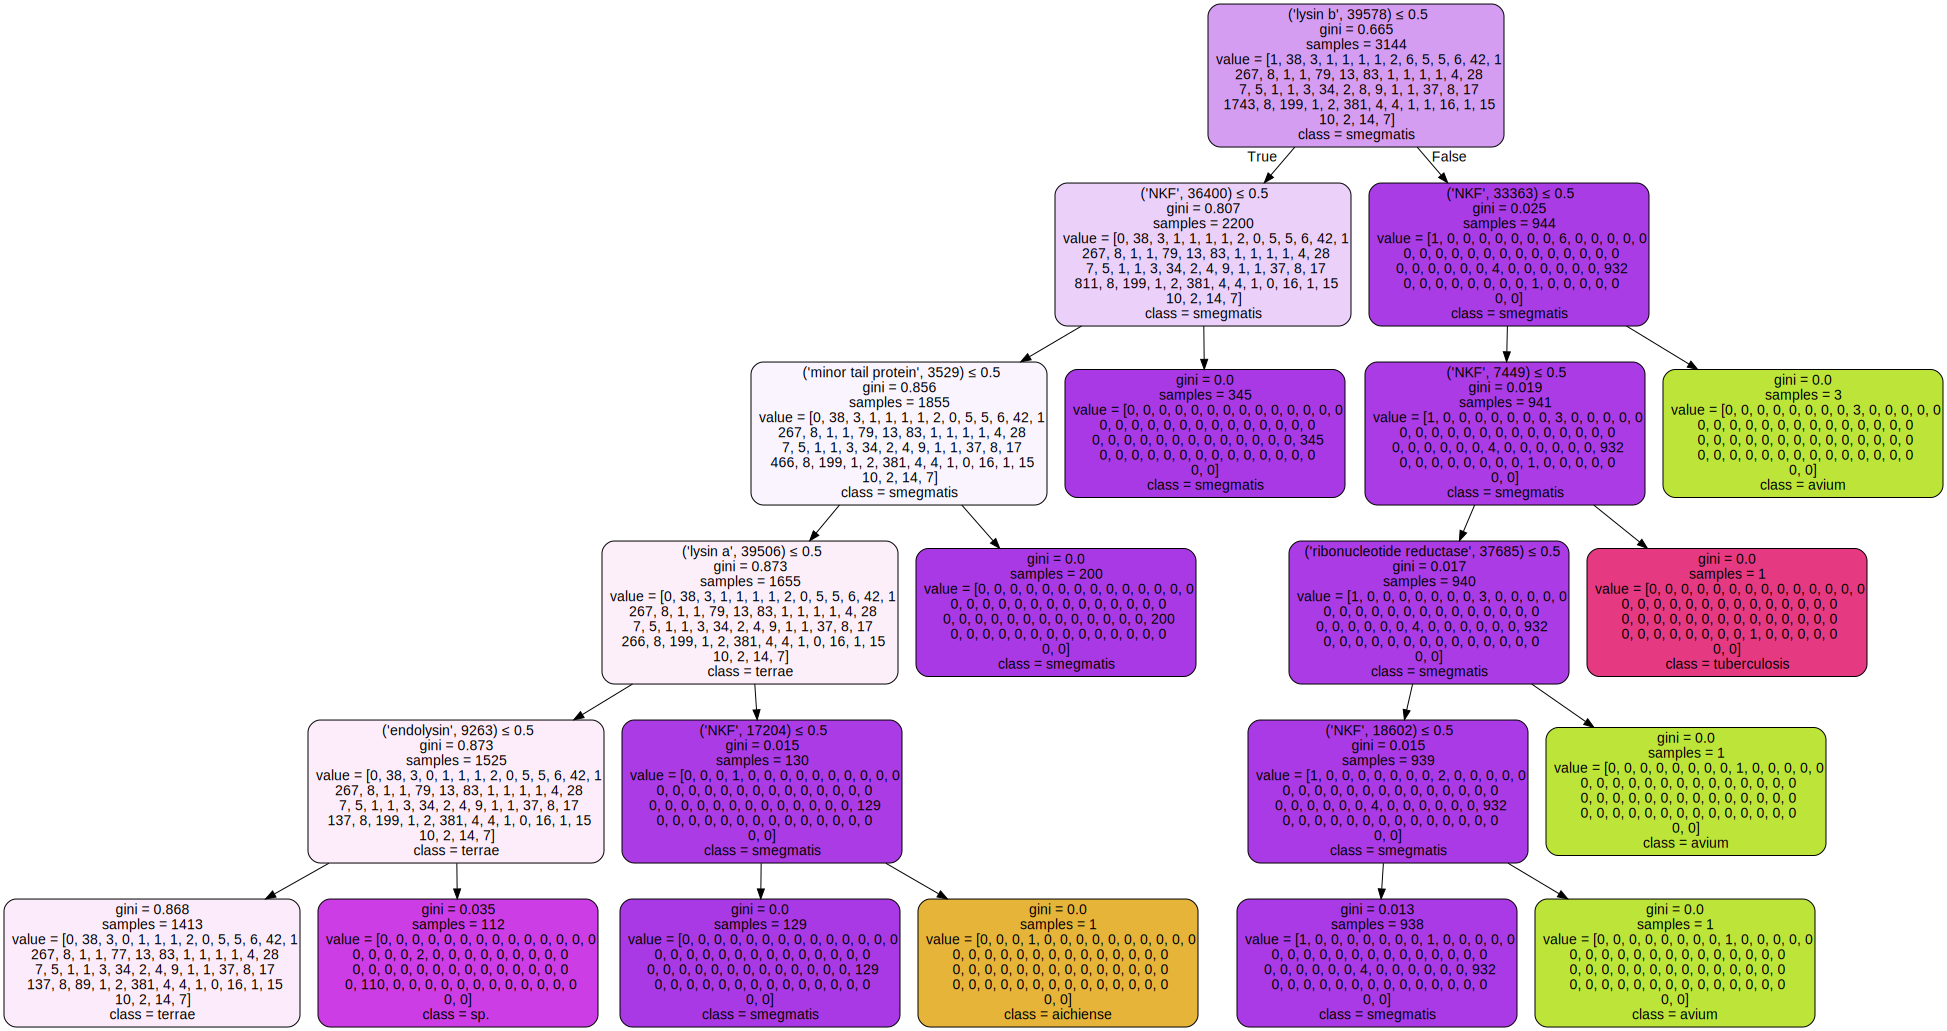

In [106]:
majority_function = []
for pham in df_genes["pham"].unique():
    list_func = list(df_genes[df_genes["pham"]==pham]["function"])
    curr_max = -1
    maj_func = "NKF"
    for i in list_func:
        if list_func.count(i) > curr_max and i != "NKF":
            curr_max = list_func.count(i)
            maj_func = i
    prop = curr_max/len(list_func)
    majority_function.append((maj_func, pham))

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=majority_function,  
                      class_names=clf.classes_,  
                      filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

Are these evolutionary correlations or functional reasons?

In [107]:
from scipy.sparse import csr_matrix
A = csr_matrix([[1, 2, 0], [0, 0, 3], [4, 0, 5]])

In [108]:
A.dot(A)

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>